# The purpose of this notebook is to create a monte carlo simulation of blackjack

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Custom Modules.
from Game import Game
from Player import Player

# Custom Functions.
from RecursePlayer import recursePlayer,dealHouse,getReward,getValue
from Q_Learning import initQ,learnPolicy,evaluatePolicy,getBestAction
from Utils import dfBestMove

# Rewards Distribution

Given random gameplay, what are the expected reward for each state-action pair?

### Here, I can specifically state which combinations I want played. However, right now, I assume plentiful cards. Will not serve as optimal policy evaluation, but rather expected rewards given a state - action pair.

So, every combination is possible (hardcoded in), and the next card drawn is uniformly, with replacement. 

Might introduce some bias. Imagine player shows [2,2], the odds of them drawing another 2 should be lower, but this method does not say so.

I use discounted rewards. For example:
- Player shows 5, they hit to get 9, hit to get 12, hit to get 20, stay, and ends up winning the hand.
- I'm most interested in the move taken when player has 20.
- How I handle this is by using the gamma hyperparameter and discounting earlier moves more

Initialize the simulation

In [2]:
blackjack = Game(Player)
cardMap = blackjack.cardMap
cardValues = blackjack.cardValues
allCards = list(cardMap.values())

moves = ['stay','hit','double','surrender','split']

pairsSplit = {(c,c):i for i,c in enumerate(allCards)}
pairsSplit = {}
count = 0
for c in allCards :
    pairsSplit[(c,c)] = count
    if c not in [10,'J','Q'] :
        count += 1
    

# initialize arrays for totals + rewards
# dimensions are (m,a,p,h)
# - m : # of possible moves
# - a : useable ace or not
# - p : # of possible totals (includes 0,1,2,3 for simplicity), PLUS # of pairs
# - h : # of possible house face-up card (includes 0,1,2,3 for simplicity)

totals = np.zeros((len(moves),2,21+1+len(pairsSplit)-3,11+1))
rewards = np.zeros((len(moves),2,21+1+len(pairsSplit)-3,11+1))

gamma = .7

nTrials = 2000

Run the trail

In [6]:
for n in range(nTrials) :
    print('{} of {}'.format(n,nTrials),end='\r')
    for i in range(len(allCards)) :
        for j in range(i,len(allCards)) :
            cards = [allCards[i],allCards[j]]
            for h in range(len(allCards)) :
                houseCards,val,houseShow = dealHouse(allCards[h],cardMap,cardValues)
                seriesOut = recursePlayer(cards,allCards[h],cardMap,cardValues)

                for r in seriesOut :
                    if len(r)==0 :
                        totals[0,0,21,houseShow] += 1
                        rewards[0,0,21,houseShow] += 1.5
                        continue
                    reward = getReward(r,val)
                    
                    # I can discount earlier moves (hence reversing the order of moves)
                    # to more accurately reflect the benefit of hitting on smaller player cards shown.
                    for g,(playerShow,move,useableAce,pairSplit,nextVal) in enumerate(r[::-1]) :
                        indPlayer = playerShow
                        if pairSplit :
                            indPlayer = 22 + pairsSplit[tuple(pairSplit)]
                        totals[moves.index(move),int(useableAce),indPlayer,houseShow] += 1   
                        rewards[moves.index(move),int(useableAce),indPlayer,houseShow] += reward*gamma**g
            
            
normalized = np.zeros(totals.shape)
for m in range(len(moves)) :
    for i in [0,1] :
        # prevent division by zero, clip totals (shouldn't happen if # iterations is high enough)
        normalized[m][i] = rewards[m][i] / np.clip(totals[m][i],a_min=1,a_max=None)
            
            
        

In [3]:
#np.save('normalized.npy',normalized)
normalized = np.load('normalized.npy')

In [4]:
noAce,useableAce,canSplit = dfBestMove(normalized,moves,pairsSplit,colorBox=True)

In [5]:
noAce

,2,3,4,5,6,7,8,9,10,11
5,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi
6,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi
7,Hi,Hi,Hi,Hi,Do,Hi,Hi,Hi,Hi,Hi
8,Hi,Do,Do,Do,Do,Hi,Hi,Hi,Hi,Hi
9,Do,Do,Do,Do,Do,Do,Do,Hi,Hi,Hi
10,Do,Do,Do,Do,Do,Do,Do,Do,Do,Hi
11,Do,Do,Do,Do,Do,Do,Do,Do,Do,Hi
12,St,St,St,St,St,Hi,Hi,Hi,Hi,Hi
13,St,St,St,St,St,Hi,Hi,Hi,Hi,Hi
14,St,St,St,St,St,Hi,Hi,Hi,Hi,Su


In [6]:
useableAce

,2,3,4,5,6,7,8,9,10,11
13,Do,Do,Do,Do,Do,Hi,Hi,Hi,Hi,Hi
14,Hi,Do,Do,Do,Do,Hi,Hi,Hi,Hi,Hi
15,Do,Do,Do,Do,Do,Hi,Hi,Hi,Hi,Hi
16,Do,Do,Do,Do,Do,Hi,Hi,Hi,Hi,Hi
17,Do,Do,Do,Do,Do,Do,Hi,Hi,Hi,Hi
18,St,Do,Do,Do,Do,St,St,St,St,Hi
19,St,St,St,St,St,St,St,St,St,St
20,St,St,St,St,St,St,St,St,St,St
21,St,St,St,St,St,St,St,St,St,St


In [7]:
canSplit

,2,3,4,5,6,7,8,9,10,11
"(2, 2)",Sp,Sp,Sp,Sp,Sp,Sp,Sp,Hi,Hi,Hi
"(3, 3)",Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp,Hi,Hi
"(4, 4)",Hi,Do,Do,Do,Do,Hi,Hi,Hi,Hi,Hi
"(5, 5)",Do,Do,Do,Do,Do,Do,Do,Do,Do,Hi
"(6, 6)",Sp,Sp,Sp,St,St,Sp,Sp,Sp,Sp,Sp
"(7, 7)",Sp,Sp,Sp,St,St,Sp,Sp,Sp,Sp,Sp
"(8, 8)",Sp,Sp,Sp,St,St,Sp,Sp,Sp,Sp,Sp
"(9, 9)",St,St,St,St,St,St,St,St,St,St
"(10, 10)",St,St,St,St,St,St,St,St,St,St
"('A', 'A')",Sp,Sp,Do,Do,Do,Sp,Sp,Sp,Sp,Sp


# Policy Generation (Control)

Can I learn an optimal policy using Monte Carlo methods?
- Greedy Algorithm
- Epsilon-Greedy Algorithm
- Thompson Sampling methods.

# Simulate game play, gather totals and rewards, normalized rewards, and display best option.

In [9]:
card_comb_all = []
card_comb = [[c1,c2] for i,c1 in enumerate(allCards) for c2 in allCards[i:]]
all_comb = [[c1,c2] for c1 in allCards for c2 in allCards]
for c in card_comb :
    for a in all_comb :
        card_comb_all.append([[c]]+[a])

In [10]:
Q = {
    'name':'e-Greedy Decay 1',
    'epsilon_decay':.00001,
    'min_epsilon':.1,
    'evaluation':[]
}

nEpisodes = int(5e5)
nPlayers = 1
gamma = .8
lr = .01
nDecks = 6
ratioPenetrate = 4/6
wagers = [1]*nPlayers

nRoundsEvaluate = 1000

moves = ['stay','hit','split','double','surrender']

earlyStop = False
e = 10 # early stopping criterion. Number of "every" that have to pass without improvement.
every = int(len(card_comb_all)/5) # interval to evaluate policy


In [11]:
blackjack = Game(
    Player,
    allowHardCodedCards=True,
    shrinkDeck=True,
    nDecks=nDecks,
    ratioPenetrate=ratioPenetrate,
    verbose=False
)

allCards = list(blackjack.cardMap.values())
Q['Q'] = initQ(moves,allCards)

r = 0
counter = 0
minPerformance = -10
while r < nEpisodes :
    
    card_comb_use = card_comb_all[r%len(card_comb_all)]

    blackjack.initRound(wagers)
    blackjack.dealInit(hardcodedCards=card_comb_use)
    if not blackjack.houseBlackjack :
        eps = max(Q['min_epsilon'],np.exp(-Q['epsilon_decay']*r)) #exponential decay factor.
        learnPolicy(blackjack,Q['Q'],nPlayers,eps,gamma,lr)

    if not r%every :
        blackjackEval = Game(Player,shrinkDeck=True,nDecks=nDecks,ratioPenetrate=ratioPenetrate,verbose=False)
        p = np.mean(evaluatePolicy(blackjackEval,Q['Q'],wagers,nRoundsEvaluate)[-1])
        Q['evaluation'].append(p)

        print('Method {} ---- {} of {} ---- EPS : {} ---- Score : {}'.format(Q['name'],r+1,nEpisodes,eps,p))

        if p < minPerformance : 
            counter += 1
        else :
            counter = 0
            bestQ = Q['Q'].copy() # "backtracking". This will be used as optimal Q value dict. 
        minPerformance = max(minPerformance,p)

    if (earlyStop) & (counter == e) :

        print('Early Stopping at Round {}.'.format(r))
        break

    r += 1

Method e-Greedy Decay 1 ---- 1 of 500000 ---- EPS : 1.0 ---- Score : -0.4075
Method e-Greedy Decay 1 ---- 3076 of 500000 ---- EPS : 0.9697179722679314 ---- Score : -0.1935
Method e-Greedy Decay 1 ---- 6151 of 500000 ---- EPS : 0.9403529457394286 ---- Score : -0.1505
Method e-Greedy Decay 1 ---- 9226 of 500000 ---- EPS : 0.911877151758615 ---- Score : -0.119
Method e-Greedy Decay 1 ---- 12301 of 500000 ---- EPS : 0.8842636625608209 ---- Score : -0.1375
Method e-Greedy Decay 1 ---- 15376 of 500000 ---- EPS : 0.8575035157075082 ---- Score : 0.016
Method e-Greedy Decay 1 ---- 18451 of 500000 ---- EPS : 0.831519939899404 ---- Score : -0.076
Method e-Greedy Decay 1 ---- 21526 of 500000 ---- EPS : 0.8063398300196023 ---- Score : -0.002
Method e-Greedy Decay 1 ---- 24601 of 500000 ---- EPS : 0.7819222249254772 ---- Score : -0.0565
Method e-Greedy Decay 1 ---- 27676 of 500000 ---- EPS : 0.7582440344259632 ---- Score : -0.057
Method e-Greedy Decay 1 ---- 30751 of 500000 ---- EPS : 0.735282867547

Method e-Greedy Decay 1 ---- 270601 of 500000 ---- EPS : 0.1 ---- Score : -0.0505
Method e-Greedy Decay 1 ---- 273676 of 500000 ---- EPS : 0.1 ---- Score : 0.032
Method e-Greedy Decay 1 ---- 276751 of 500000 ---- EPS : 0.1 ---- Score : -0.005
Method e-Greedy Decay 1 ---- 279826 of 500000 ---- EPS : 0.1 ---- Score : -0.0255
Method e-Greedy Decay 1 ---- 282901 of 500000 ---- EPS : 0.1 ---- Score : -0.004
Method e-Greedy Decay 1 ---- 285976 of 500000 ---- EPS : 0.1 ---- Score : 0.0305
Method e-Greedy Decay 1 ---- 289051 of 500000 ---- EPS : 0.1 ---- Score : 0.023
Method e-Greedy Decay 1 ---- 292126 of 500000 ---- EPS : 0.1 ---- Score : 0.049
Method e-Greedy Decay 1 ---- 295201 of 500000 ---- EPS : 0.1 ---- Score : -0.041
Method e-Greedy Decay 1 ---- 298276 of 500000 ---- EPS : 0.1 ---- Score : -0.073
Method e-Greedy Decay 1 ---- 301351 of 500000 ---- EPS : 0.1 ---- Score : -0.013
Method e-Greedy Decay 1 ---- 304426 of 500000 ---- EPS : 0.1 ---- Score : 0.0225
Method e-Greedy Decay 1 ---- 

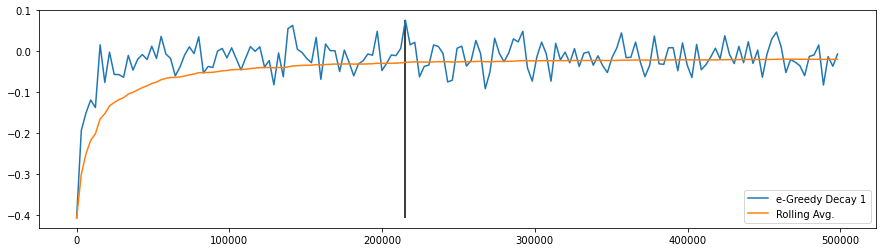

In [12]:
plt.figure(figsize=(15,4))
plt.plot(
    np.arange(0,len(Q['evaluation']))*every,
    Q['evaluation'],
    label=Q['name']
)
plt.plot(
    np.arange(0,len(Q['evaluation']))*every,
    np.cumsum(Q['evaluation']) / np.arange(1,len(Q['evaluation'])+1),
    label='Rolling Avg.'
)
plt.vlines(x=np.argmax(Q['evaluation'])*every,ymin=min(Q['evaluation']),ymax=max(Q['evaluation']),color='k')

plt.legend()
plt.show()

In [13]:
np.save('Q',bestQ)
#Qlearned = np.load('Q.npy',allow_pickle=True).item()

Evaluate new policy, as well as a random one, and a simple one.

Generating Random Rewards...
Generating Learned Rewards...
Generating Meh Rewards...
Done


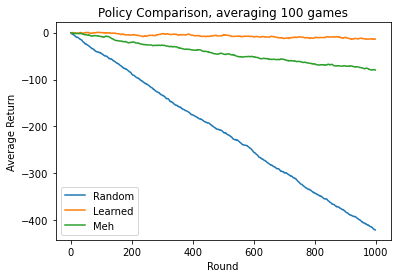

In [15]:
nRoundsEvaluate = 1000

print('Generating Random Rewards...')
randQ = initQ(['stay','hit','split','double','insurance','surrender'],allCards)
blackjack = Game(Player,shrinkDeck=True,nDecks=nDecks,ratioPenetrate=ratioPenetrate,verbose=False)
randomRewards = np.mean([np.cumsum(evaluatePolicy(blackjack,randQ,wagers,nRoundsEvaluate)[0]) for _ in range(10)],axis=0)

print('Generating Learned Rewards...')
blackjack = Game(Player,shrinkDeck=True,nDecks=nDecks,ratioPenetrate=ratioPenetrate,verbose=False)
try : # if Qlearned has been defined, read in from file, else use the Q dict trained in this notebook.
    learnedRewards = np.mean([np.cumsum(evaluatePolicy(blackjack,Qlearned,wagers,nRoundsEvaluate)[0]) for _ in range(10)],axis=0)
except :
    learnedRewards = np.mean([np.cumsum(evaluatePolicy(blackjack,bestQ,wagers,nRoundsEvaluate)[0]) for _ in range(10)],axis=0)

print('Generating Meh Rewards...')
somewhatSmartQ = initQ(['stay','hit','split','double','insurance','surrender'],allCards)
for split,s_pairs in somewhatSmartQ.items() :
    for s,vals in s_pairs.items() :
        p,h,a = s
        if split=='canSplit' :
            if p == 'A' :
                p = 12
            else :
                p = p*2
        if p > 17 :
            vals['stay'] = 1
        else :
            vals['hit'] = 1

blackjack = Game(Player,shrinkDeck=True,nDecks=nDecks,ratioPenetrate=ratioPenetrate,verbose=False)
mehRewards = np.mean([np.cumsum(evaluatePolicy(blackjack,somewhatSmartQ,wagers,nRoundsEvaluate)[0]) for _ in range(10)],axis=0)
print('Done')

plt.title('Policy Comparison, averaging 100 games')
plt.plot(randomRewards,label='Random')
plt.plot(learnedRewards,label='Learned')
plt.plot(mehRewards,label='Meh')
plt.xlabel('Round')
plt.ylabel('Average Return')
plt.legend()
plt.show()

Play a hand according to learned policy.

In [53]:
blackjack = Game(Player,verbose=False)

blackjack.initRound(wagers=[1])
blackjack.dealInit()
player = blackjack.players[0] # only 1 player, so i'll just extract that specific player module.
houseShow = blackjack.getHouseShow(showValue=True)

while not player.isDone() :

    playerShow,canSplit,useableAce,card1 = player.getValue()

    policy = player.getValidMoves(houseShow)
    policy = [p for p in policy if p!='insurance']
    try :
        if canSplit :
            move = getBestAction(Qlearned['canSplit'][(card1,houseShow,useableAce)],policy,-1)
        else :
            move = getBestAction(Qlearned['noSplit'][(playerShow,houseShow,useableAce)],policy,-1)
    except :
        if canSplit :
            move = getBestAction(bestQ['canSplit'][(card1,houseShow,useableAce)],policy,-1)
        else :
            move = getBestAction(bestQ['noSplit'][(playerShow,houseShow,useableAce)],policy,-1)
    print(player.cards,move)
    
    blackjack.stepPlayer(player,move)
    
blackjack.stepHouse()

print(blackjack.house.cards)
blackjack.getResults()

[['A', 5]] hit
[['A', 5, 7]] hit
[['A', 5, 7, 5]] stay
[['A', 2, 'K', 3, 2]]


([['push']], [0])